In [1]:
!pip install gym pyvirtualdisplay
!sudo apt-get install -y xvfb python-opengl ffmpeg
!sudo apt-get update
!sudo apt-get install cmake
!pip install --upgrade setuptools
!pip install ez_setup
!pip install gym[atari]
!conda install -c conda-forge pyglet -y


# install required system dependencies
!sudo apt-get install -y xvfb x11-utils
# install required python dependencies
!pip install gym[box2d]==0.17.* \
            pyvirtualdisplay==0.2.* \
            PyOpenGL==3.1.* \
            PyOpenGL-accelerate==3.1.*

!sudo apt install freeglut-devel
!pip install hyperopt




Reading package lists... Done
Building dependency tree       
Reading state information... Done
ffmpeg is already the newest version (7:4.1.6-1~deb10u1).
python-opengl is already the newest version (3.1.0+dfsg-2).
xvfb is already the newest version (2:1.20.4-1+deb10u2).
0 upgraded, 0 newly installed, 0 to remove and 53 not upgraded.
Hit:1 http://packages.cloud.google.com/apt cloud-sdk-buster InRelease
Hit:2 http://packages.cloud.google.com/apt google-cloud-packages-archive-keyring-buster InRelease
Hit:3 http://packages.cloud.google.com/apt gcsfuse-buster InRelease            
Hit:4 http://security.debian.org/debian-security buster/updates InRelease      
Hit:5 http://deb.debian.org/debian buster InRelease                            
Hit:6 http://packages.cloud.google.com/apt google-compute-engine-buster-stable InRelease
Hit:7 http://deb.debian.org/debian buster-updates InRelease                    
Hit:8 http://deb.debian.org/debian buster-backports InRelease                  
Hit:9 ht

In [2]:
import gym
from gym import logger as gymlogger
from gym.wrappers import Monitor
gymlogger.set_level(40) #error only

import numpy as np
import random
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import math
import glob
import io
import base64
from IPython.display import HTML
from IPython import display as ipythondisplay

import argparse
import pickle
from collections import namedtuple
from itertools import count

import os, time, json
import numpy as np
import matplotlib.pyplot as plt


import torch
import torch.nn as nn
import torch.optim as optim
from timeit import default_timer as timer 

from torch.utils.data.sampler import BatchSampler, SubsetRandomSampler

from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()

<Display cmd_param=['Xvfb', '-br', '-nolisten', 'tcp', '-screen', '0', '1400x900x24', ':1007'] cmd=['Xvfb', '-br', '-nolisten', 'tcp', '-screen', '0', '1400x900x24', ':1007'] oserror=None return_code=None stdout="None" stderr="None" timeout_happened=False>

In [22]:
import argparse
import pickle
from collections import namedtuple
from itertools import count

import os, time, json
import numpy as np
import matplotlib.pyplot as plt

import gym
import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data.sampler import BatchSampler, SubsetRandomSampler

# taken from https://github.com/sweetice/Deep-reinforcement-learning-with-pytorch, with heavy modifications.

class Net(nn.Module):
    def __init__(self, num_state, num_action):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(num_state, 64)
        self.activation = nn.ReLU() 
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, num_action)

    def forward(self, x):
        x = self.activation(self.fc1(x))
        action_prob = self.fc2(x)
        return action_prob


class DQN():
    def __init__(self, num_state, num_action, params):
        super(DQN, self).__init__()

        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        # data collection aids
        self.name = 'agents/' + params.env_name + '_' + params.model_name
        self.losses = []
        self.rewards = []
        self.params = params 
        if self.params.mode == 'test':
            self.load(self.name)
        else:
            self.target_net, self.act_net = Net(num_state, num_action), Net(num_state, num_action)
            self.target_net, self.act_net = self.target_net.to(self.device), self.act_net.to(self.device)
            self.unpack_params()
            self.loss_func = nn.MSELoss()
            self.num_actions = num_action 
            self.num_states = num_state
            self.memory_count = 0 
            self.update_count = 0

    def unpack_params(self):
        self.epsilon = self.params.exploration_noise
        self.optimizer = get_optimizer(self.params.optimizer, self.act_net, self.params.learning_rate)
        self.capacity = self.params.capacity
        self.memory = [None]*self.capacity
        self.update_point = self.params.update_count 
        self.gamma = self.params.gamma
        self.batch_size = int(self.params.batch_size)
        self.game = self.params.env_name
        self.epsilon_decay = self.params.epsilon_decay 

    def select_action(self,state):
        state = torch.tensor(state, dtype=torch.float).unsqueeze(0)
        state = state.to(self.device)
        value = self.act_net(state)
        action_max_value, index = torch.max(value, 1)
        action = index.item()
        if np.random.uniform() <= self.epsilon: 
            action = np.random.choice(range(self.num_actions), 1).item()
        return action

    def store_transition(self,transition):
        index = self.memory_count % self.capacity
        self.memory[index] = transition
        self.memory_count += 1

    def update_epsilon(self, t):
        self.epsilon = 0.1 + 0.99 * np.exp(-t/20000)
    
    def update_target_network_weights(self):
        if self.update_count == self.update_point:
            self.update_count = 0 
            self.target_net.load_state_dict(self.act_net.state_dict())

    def update(self):
        if self.memory_count >= self.capacity:

            # convert inputs to torch tensors. 
            state = torch.Tensor([t.old_state for t in self.memory]).float()
            action = torch.LongTensor([t.action for t in self.memory]).view(-1,1).long()
            reward = torch.Tensor([t.reward for t in self.memory]).float()
            next_state = torch.Tensor([t.new_state for t in self.memory]).float()

            # move to device. 
            state = state.to(self.device)
            action = action.to(self.device)
            reward = reward.to(self.device)
            next_state = next_state.to(self.device)

            # normalize rewards. 
            reward = (reward - reward.mean()) / (reward.std() + 1e-7)

            # update Q value
            with torch.no_grad():
                target_v = reward + self.gamma * self.target_net(next_state).max(1)[0]
            
            batch_loss = 0

            # sample from replay buffer, update actor network. 
            for index in BatchSampler(SubsetRandomSampler(range(len(self.memory))), batch_size=self.batch_size, drop_last=False):
                v = (self.act_net(state).gather(1, action))[index]
                loss = self.loss_func(target_v[index].unsqueeze(1), (self.act_net(state).gather(1, action))[index])
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
                batch_loss += loss.item()
                
                # update target Q network when sufficient iterations have passed. 
                self.update_count +=1
                self.update_target_network_weights()

            self.losses.append(batch_loss/self.batch_size)
            self.rewards.append(reward.mean().item())
    
    def save(self, ep_number):
        if not os.path.isdir('agents'):
            os.mkdir('agents/')
        act_model_path = 'agents/' + self.params.model_name + '_' + self.game + '_actor_episode' + str(ep_number) + '.pth'
        target_model_path = 'agents/' + self.params.model_name + '_' + self.game + '_target_episode' + str(ep_number)+ '.pth'
        torch.save(self.act_net.state_dict(), act_model_path)
        torch.save(self.target_net.state_dict(), target_model_path)

        save_dic = vars(self.params)

        save_dic['num_actions'] = self.num_actions 
        save_dic['num_states'] = self.num_states 
        save_dic['memory_count'] = self.memory_count 
        save_dic['update_count'] = self.update_count
        save_dic['losses'] = self.losses
        save_dic['rewards'] = self.rewards

        filename = self.name + '.json'
        with open(filename, 'w') as fp:
            json.dump(save_dic, fp, indent=4)

    def load(self, name):
        # name = 'agents/' + game + '_' + model_name
        filename = name + '.json'
        print('loading from : ', filename) 
        try:
            with open(filename, 'r') as fp:
                data = json.load(fp)
        except FileNotFoundError:
            raise FileNotFoundError("Specified agent does not exist. Aborting.")
        
        self.params = argparse.Namespace(**data)
        self.num_actions = data['num_actions']
        self.num_states = data['num_states']
        ep_number = self.params.num_episodes - 1
        act_model_path = 'agents/' + self.params.model_name + '_' + self.params.env_name + '_actor_episode' + str(ep_number) + '.pth'
        target_model_path = 'agents/' + self.params.model_name + '_' + self.params.env_name + '_target_episode' + str(ep_number)+ '.pth'

        # load the models.
        self.act_net, self.target_net = Net(self.num_states, self.num_actions), Net(self.num_states, self.num_actions)
        self.act_net, self.target_net = self.act_net.to(self.device), self.target_net.to(self.device)
        self.act_net.load_state_dict(torch.load(act_model_path))
        self.target_net.load_state_dict(torch.load(target_model_path))
        
        # load other parameters.
        self.unpack_params() 
        self.memory_count = data['memory_count']
        self.update_count = data['update_count']
        self.losses = data['losses']
        self.rewards = data['rewards']
    
    def get_losses(self):
        return self.losses
    
    def get_rewards(self):
        return self.rewards


class Transition(object):
    def __init__(self, old_state, action, new_state, reward: float, terminate_: bool):
        self.old_state = old_state
        self.action = action
        self.new_state = new_state
        self.reward = reward
        self.terminate = terminate_

    @property
    def terminate(self):
        return self.__terminate

    @terminate.setter
    def terminate(self, terminate_):
        if isinstance(terminate_, bool):
            self.__terminate = terminate_
        else:
            raise TypeError(f'{terminate_} should be bool type')

    def get_transition_tuple(self) -> tuple:
        return self.old_state, self.action, self.new_state, self.reward, self.terminate


def initialize_game(params):
    env = gym.make(params.env_name).unwrapped
    num_state = env.observation_space.shape[0]
    num_action = env.action_space.n
    dqn = DQN(num_state, num_action, params)
    return env, num_state, num_action, dqn 


def get_optimizer(name, net, learning_rate):
    if name.lower() == 'adam':
        optimizer = optim.Adam(net.parameters(), learning_rate)
    elif name.lower() == 'adagrad':
        optimizer = optim.Adagrad(net.parameters(), learning_rate)
    elif name.lower() == 'adadelta':
        optimizer = optim.Adadelta(net.parameters(), learning_rate)
    elif name.lower() == 'sgd':
        optimizer = optim.SGD(net.parameters(), learning_rate)
    elif name.lower() == 'rmsprop':
        optimizer = optim.RMSprop(net.parameters(), learning_rate)
    return optimizer 


def display_state_action_dims(games):
    for env_name in games:
        env = gym.make(env_name).unwrapped
        num_state = env.observation_space.shape[0]
        num_action = env.action_space.n
        print("%s | num_states : %s | num_actions: %s" % (env_name, num_state, num_action))


def run(params, return_agent=False):
    params = argparse.Namespace(**params)
    env, num_state, num_action, agent = initialize_game(params)
    all_rewards = []
    for i_ep in range(params.num_episodes):
        state = env.reset()
        if i_ep % 10 == 0 and i_ep > 0:
            print("episode: %s" % i_ep)
        # if i_ep % (params.log_interval-1) == 0 and i_ep > 0:
        #     agent.save(i_ep)
        for t in range(params.num_iterations):
            action = agent.select_action(state)
            next_state, reward, done, info = env.step(action)
            if params.render: env.render()
            transition = Transition(state, action, next_state, reward, done)
            agent.store_transition(transition)
            if (done or t == params.num_iterations - 1): 
                agent.update()
            all_rewards.append(reward)
            agent.update_epsilon(t)

    if return_agent:
        return agent 
    else:
        return -np.mean(all_rewards)


def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else: 
    print("Could not find video")
    

def wrap_env(env):
  env = Monitor(env, './video', force=True)
  return env


def test_agent(agent, env_name):
    env = wrap_env(gym.make(env_name).unwrapped)
    observation = env.reset()
    num_iters = 0
    while True:
        if num_iters > 1000:
            break
        env.render() 
        action = agent.select_action(observation)
        next_state, reward, done, info = env.step(action)
        num_iters += 1
        if done:
            env.reset() 
#         if done: break 
        
    env.close()
    show_video() 

In [23]:
params = {
            'mode':'train',
            'render': False,
            'log_interval': 100,
            'env_name': 'LunarLander-v2', 
            'num_episodes': 150,
            'num_iterations':10000,
            'exploration_noise': 0.3, 
            'capacity': 5000,
            'model_name': 'trial_model',
            'update_count': 10,
            'gamma': 0.99,
            'batch_size': 128,
            'optimizer': 'adam',
            'learning_rate': 0.01,
            'epsilon_decay': 0.999995
        }

In [19]:
basic_agent = run(params, return_agent=True)

KeyboardInterrupt: 

In [ ]:
plt.figure()
plt.plot(range(len(basic_agent.rewards)), basic_agent.rewards)
plt.title("Reward vs Iteration - Basic Agent")
plt.xlabel("Iterations")
plt.ylabel("Reward")
plt.show()

In [ ]:
p

In [24]:
import numpy as np 
from hyperopt import hp, fmin, tpe, Trials

def bayesian_opt(run, space, max_evals=50):
    trials = Trials()
    best_setting = fmin(run, space, algo=tpe.suggest, max_evals=100, trials=trials)
    return best_setting, trials  

In [ ]:
optimizers = ['adam', 'rmsprop', 'sgd', 'adagrad']
default_params = {'mode': 'train',
                  'render': False,
                  'log_interval': 1000,
                  'env_name': 'LunarLander-v2',
                  'num_iterations': 100, 
                  'num_episodes': 100,
                  'capacity': 5000,
                  'model_name': 'trial_model'} 

hypopt_params = {
                'exploration_noise': hp.uniform('exploration_noise', 0, 1),
                'update_count': hp.quniform('update_count', 10, 100, 10),
                'gamma': hp.uniform('gamma', 0, 1),
                'batch_size': hp.quniform('batch_size', 2, 512, 2),
                'optimizer': hp.choice('optimizer', optimizers),
                'learning_rate': hp.uniform('learning_rate', 0, 1),
                'epsilon_decay': hp.uniform('epsilon_decay', 0, 1)
                }

space = {}
space.update(default_params)
space.update(hypopt_params)
best_setting, trials = bayesian_opt(run, space, max_evals=1000)

In [54]:
final_params = default_params 
final_params.update(best_setting)
final_params['optimizer'] = optimizers[final_params['optimizer'] - 1]
final_params['num_iterations'] *= 100 

avg best error: 11.867429620665076


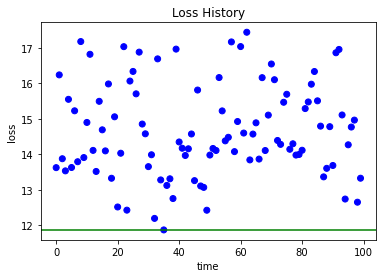

In [46]:
from hyperopt import plotting 

plotting.main_plot_history(trials)

In [56]:
opt_agent = run(final_params, return_agent=True)

episode: 10
episode: 20
episode: 30
episode: 40
episode: 50
episode: 60
episode: 70
episode: 80
episode: 90


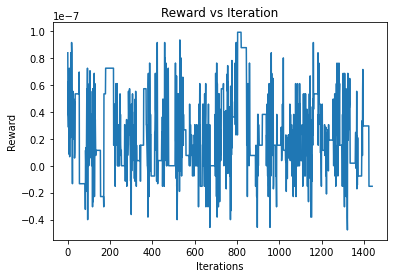

In [57]:
plt.figure()
plt.plot(range(len(opt_agent.rewards)), opt_agent.rewards)
plt.title("Reward vs Iteration")
plt.xlabel("Iterations")
plt.ylabel("Reward")
plt.show()

In [ ]:
# visualization script. has about 50/50 chance of crashing the notebook, so run at your own risk!
test_agent(basic_agent, params['env_name'])

In [ ]:
test_agent(opt_agent, final_params['env_name'])